### Classifying healthy people and diabetic people based on their body measurements and body compositions

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import ExcelWriter
from pandas import ExcelFile

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score,cross_val_predict,cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score


In [9]:
address='DataSet/NHANES 1999-2006.xlsx'
df=pd.read_excel(address)

In [664]:
#Feature extraction (Research)
feature_dem=['RIAGENDR','RIDAGEYR','RACETH']
feature_bc=['DXDTOFAT','DXDTOLE','DXXTRFAT','DXXLAFAT','DXXLLFAT']
feature_cal=['DRXTKCAL','DRXTCARB','DRXTPROT','DRXTTFAT','DRXTSFAT']
feature_BM=['bmxwt','bmxht','bmxbmi','bmxwaist','BMXTHICR','BMXARMC','BMXLEG','BMXCALF','BMXARML']
feature_diab=['DIQ050','DIQ070','MCQ250A']
feature_bp=['BPQ020']
feature_act=['PAD020','PAD080','PAQ100','PAD120','PAD160','PAQ180','PAQ480','PAD200','PAD320','PAD440','PAQ050Q','PAQ050U','PAQ540','PAQ500','PAQ520']

feature_sm=['SMQ020','SMQ040']
feature_ed=['DMDEDUC2','DMDHHSIZ']
target=['lbxglu']
#feature_preg=['RIDEXPRG']

feature_tot=target+feature_dem+ feature_cal+feature_BM+feature_diab+feature_bp+feature_act+feature_sm+feature_ed+feature_bc
#feature_tot=target+feature_dem+ feature_cal+feature_BM+feature_diab+feature_bp+feature_sm+feature_ed+feature_bc

df_diab=df[feature_tot]
df_diab.shape

(29026, 46)

In [665]:
#Defining Diabetes/Pre-Diabetes and healthy classes

df_diab=df_diab.dropna(subset=['lbxglu'])
print(df_diab.shape)
df_diab['Diabetic']= df_diab['lbxglu'].apply(lambda x: 1 if (x>100)  else 0) # defining two classes in Diabetic column

(12037, 46)


In [666]:
# considering only subject that are not taking insulin or pills because it affects their 
df_diab=df_diab.loc[(df_diab['DIQ070']!=1 )&(df_diab['DIQ050']!=1)]  
df_diab=df_diab.drop(columns=['DIQ070', 'DIQ050'])
print(df_diab.shape)
df_diab=df_diab.loc[(df_diab['RIDAGEYR']>=18)] 
print(df_diab.shape)

(11374, 45)
(8741, 45)


In [667]:
#Imputations
df_diab.isnull().sum()
df_diab['MCQ250A']=df_diab['MCQ250A'].fillna(2) #If no input --> No family history
df_diab['BPQ020']=df_diab['BPQ020'].fillna(2) #If no input --> No blood pressure history
df_diab['PAQ050U']=df_diab['PAQ050U'].fillna(1)
df_diab['PAQ050Q']=df_diab['PAQ050Q'].fillna(0)
df_diab['SMQ020']=df_diab['SMQ020'].fillna(2)
df_diab['PAQ540']=df_diab['PAQ540'].fillna(3)
df_diab['PAQ500']=df_diab['PAQ500'].fillna(3)
df_diab['PAQ520']=df_diab['PAQ520'].fillna(3)
df_diab.loc[df_diab['SMQ020']==2 , ['SMQ040']]=3;  #non-smoker

df_diab.groupby(['SMQ020']).size()
#df_diab.isnull().sum()

SMQ020
1.0    3726
2.0    5015
dtype: int64

In [668]:
#Imputations
features=['PAQ480','PAD200','PAD440','PAD320','DMDEDUC2']
from sklearn.impute import SimpleImputer
imp_freq= SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_freq.fit(df_diab[features])
df_diab[features]=imp_freq.transform(df_diab[features])

In [669]:
#Imputations
features_con=feature_bc+feature_cal+feature_BM
from sklearn.impute import KNNImputer
knnimputer = KNNImputer(n_neighbors=10)
#imp_freq= SimpleImputer(missing_values=np.nan, strategy='most_frequent')
knnimputer.fit_transform(df_diab[features_con])
#imp_freq.fit(df_diab[features])
df_diab[features_con]=knnimputer.fit_transform(df_diab[features_con])

In [670]:
df_diab['min_act']=0
df_diab.loc[df_diab['PAD200']==1 , ['min_act']]=1;
df_diab.loc[df_diab['PAD440']==1 , ['min_act']]=1;
df_diab.loc[df_diab['PAD320']==1 , ['min_act']]=1;
df_diab=df_diab.drop(columns=['PAD200', 'PAD440','PAD320','PAQ180'])

In [671]:
#Function for removing outliers

def outliers_IQR2(data,fs, t=3):
    threshold = t
    Q1 = data[fs].quantile(0.25)
    Q3 = data[fs].quantile(0.75)
    IQR = Q3 - Q1
    
    dataf=data[~((data[fs] <(Q1 - threshold * IQR)) | (data[fs] > (Q3 + threshold * IQR)))]
    return dataf

In [672]:
df_diab2= outliers_IQR2(df_diab,'lbxglu',3)
print(df_diab2.shape)

(8571, 42)


In [673]:
#Feature engineering for activity level (making new features)

df_diab2.loc[df_diab2['PAD020']!=1 , ['PAD080']]=0;  
df_diab2.loc[df_diab2['PAQ100']!=1 , ['PAD120']]=0;
df_diab2.loc[df_diab2['PAQ100']!=1 , ['PAD160']]=0;

#df_diab2['Act'] : daily activity (hour)
df_diab2['W']=1 #defult is daily
df_diab2.loc[df_diab2['PAQ050U']==1 , ['W']]=1;
df_diab2.loc[df_diab2['PAQ050U']==2 , ['W']]=7;
df_diab2.loc[df_diab2['PAQ050U']==3 , ['W']]=30;

df_diab2['Act']=(((df_diab2['PAD080']*df_diab2['PAQ050Q']/df_diab2['W']*7)+(df_diab2['PAD120']*df_diab2['PAD160']/7)))
#df_diab2['Act']=(df_diab2['PAD080'])/60

df_diab2['Act_level']=0
df_diab2.loc[df_diab2['Act']<=150 , ['Act_level']]=0;
#df_diab2.loc[(df_diab2['Act']<150) & (df_diab2['Act']>10), ['Act_level']]=1;
df_diab2.loc[(df_diab2['Act']>150), ['Act_level']]=1;

#df_diab2=df_diab2.drop(columns=['PAD080', 'PAQ050Q','W','PAD120','PAD160','PAQ050U','PAD020','PAQ100'])

df_diab2['cal_level']=0
df_diab2.loc[df_diab2['DRXTKCAL']<=2000 , ['cal_level']]=0;
df_diab2.loc[(df_diab2['DRXTKCAL']>2000), ['cal_level']]=1;


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user

In [674]:
df_diab2.isnull().sum()

lbxglu        0
RIAGENDR      0
RIDAGEYR      0
RACETH        0
DRXTKCAL      0
DRXTCARB      0
DRXTPROT      0
DRXTTFAT      0
DRXTSFAT      0
bmxwt         0
bmxht         0
bmxbmi        0
bmxwaist      0
BMXTHICR      0
BMXARMC       0
BMXLEG        0
BMXCALF       0
BMXARML       0
MCQ250A       0
BPQ020        0
PAD020        2
PAD080        6
PAQ100        5
PAD120        8
PAD160       12
PAQ480        0
PAQ050Q       0
PAQ050U       0
PAQ540        0
PAQ500        0
PAQ520        0
SMQ020        0
SMQ040        0
DMDEDUC2      0
DMDHHSIZ      0
DXDTOFAT      0
DXDTOLE       0
DXXTRFAT      0
DXXLAFAT      0
DXXLLFAT      0
Diabetic      0
min_act       0
W             0
Act          18
Act_level     0
cal_level     0
dtype: int64

(8571, 46)


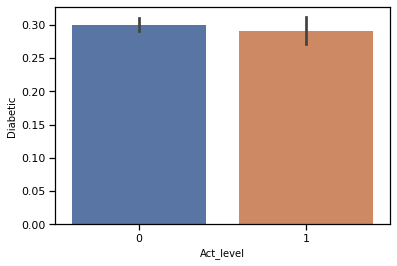

In [675]:
#df_diab2=df_diab2.dropna(subset=['Act'])
#df_diab3= outliers_IQR2(df_diab2,'lbxglu',3)

print(df_diab2.shape)
#sns.distplot(df_diab3.Act , color="olive")
#ax =sns.scatterplot(x="lbxglu", y="Act", data=df_diab2,alpha=0.4)
ax =sns.barplot(x="Act_level", y="Diabetic", data=df_diab2,alpha=1)

In [680]:

df_diab3=df_diab2

#df_diab3['Inact']=df_diab3['PAQ480'].apply(lambda x: 1 if (6>x>=3)  else 0) #more than 3 hours TV: inactive=1
#df_diab3['gen_act']=df_diab3['PAQ180'].apply(lambda x: 1 if (x>1)  else 0)  #low physical activity: gen_act=0
df_diab3['Bl_pres']=df_diab3['BPQ020'].apply(lambda x: 1 if (x==1)  else 0)
df_diab3['Fa_hist']=df_diab3['MCQ250A'].apply(lambda x: 1 if (x==1)  else 0)
df_diab3['SMQ']=df_diab3['SMQ020'].apply(lambda x: 1 if (x==1)  else 0)
df_diab3['Educ']=df_diab3['DMDEDUC2'].apply(lambda x: 1 if (x>=2)  else 0) #Not having Diploma: Educ=0
df_diab3['HHS']=df_diab3['DMDHHSIZ'].apply(lambda x: 1 if (x>=3)  else 0) #houshold size more than 2: HHS=1

df_diab3.shape


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user

(8571, 51)

In [681]:
print(df_diab3.shape)
df_diab3=df_diab3.dropna()
print(df_diab3.shape)
df_diab4=df_diab3

(8571, 51)
(8548, 51)


In [682]:
#df_diab4.gen_act.value_counts()
df_diab3.groupby(['Act_level']).size()


Act_level
0    6656
1    1892
dtype: int64

In [322]:
feature_bc=['DXDTOFAT','DXDTOLE','DXXTRFAT','DXXLAFAT','DXXLLFAT']

In [683]:
import math

df_diab5=df_diab4

# df_diab5['fat_ratio1']=df_diab5['DXXTRFAT']+(df_diab5['DXXLAFAT'])*2/(2*df_diab5['DXXLLFAT'])
# df_diab5['fat_ratio2']=df_diab5['DXXLLFAT']/(df_diab5['DXDTOFAT'])
# df_diab5['fat_ratio3']=df_diab5['DXXLAFAT']/(df_diab5['DXDTOFAT'])

# df_diab5['fat_ratio']=df_diab5['DXXTRFAT']/df_diab5['DXDTOFAT']
# df_diab5['fat_per']=df_diab5['DXDTOFAT']/df_diab5['bmxwt']
# df_diab5['fat_per2']=df_diab5['DXDTOFAT']/df_diab5['DXDTOLE']
# df_diab5['WCI']=df_diab5['bmxwaist']/(df_diab5['bmxht'].apply(np.sqrt))
# df_diab5['Cal_age']=df_diab5['DRXTKCAL']*(df_diab5['RIDAGEYR']/20)


# ax =sns.scatterplot(x="fat_ratio", y="lbxglu", data=df_diab5,alpha=0.4)

In [878]:
ax =sns.barplot(x="DMDEDUC2", y="Diabetic", data=df_diab2,alpha=1)
df_diab3.groupby(['DMDEDUC2']).size()

DMDEDUC2
1.0     904
2.0    1374
3.0    1852
4.0    2006
5.0    1253
dtype: int64

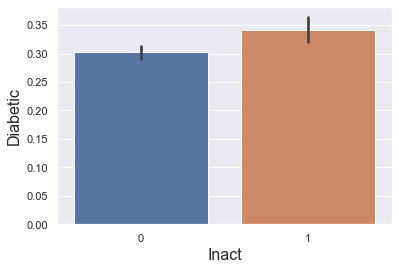

In [933]:
ax =sns.barplot(x="Inact", y="Diabetic", data=df_diab4,alpha=1)

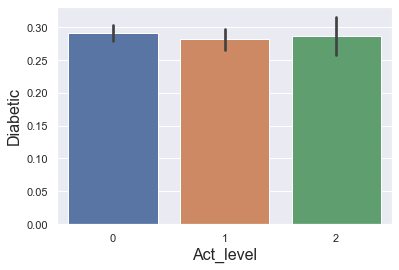

In [483]:
ax =sns.barplot(x="Act_level", y="Diabetic", data=df_diab4,alpha=1)

In [202]:
ax =sns.barplot(x="DMDHHSIZ", y="Diabetic", data=df_diab2,alpha=1)

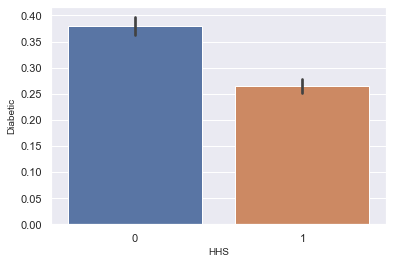

In [584]:
ax =sns.barplot(x="HHS", y="Diabetic", data=df_diab4,alpha=1)

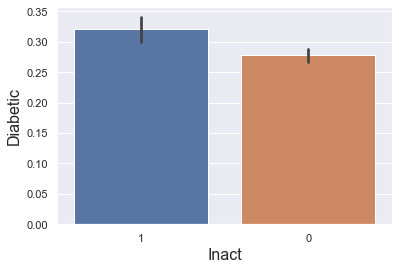

In [509]:

ax =sns.barplot(x="Inact", y="Diabetic",order=[1, 0], data=df_diab4,alpha=1)


PAQ540
1.0     835
2.0    3683
3.0    1568
dtype: int64

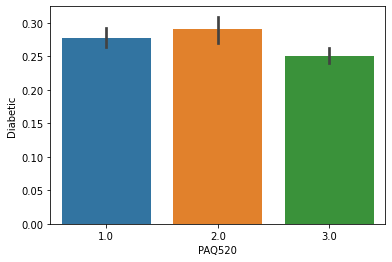

In [61]:
ax =sns.barplot(x="PAQ520", y="Diabetic", data=df_diab,alpha=1)
df_diab.groupby(['PAQ540']).size()

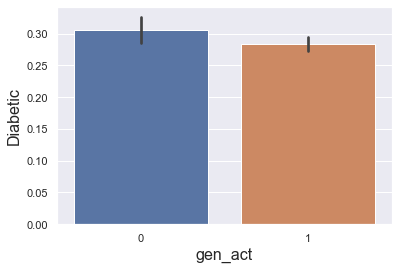

In [508]:
ax =sns.barplot(x="gen_act", y="Diabetic", data=df_diab4,alpha=1)

In [585]:
ax =sns.barplot(x="BPQ020", y="Diabetic", data=df_diab4,alpha=1)

In [502]:
ax =sns.barplot(x="Fa_hist", y="Diabetic",order=[1, 0], data=df_diab4,alpha=1)

In [490]:
ax =sns.barplot(x="SMQ020", y="Diabetic", data=df_diab4,alpha=1)

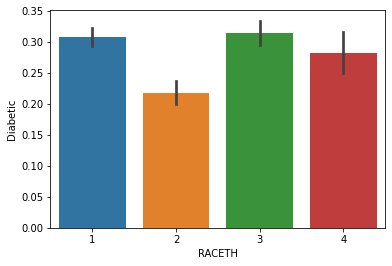

In [367]:
ax =sns.barplot(x="RACETH", y="Diabetic", data=df_diab4,alpha=1)

Diabetic  PAQ520
0         1.0       2108
          2.0       1171
          3.0       2735
1         1.0        961
          2.0        498
          3.0       1098
dtype: int64

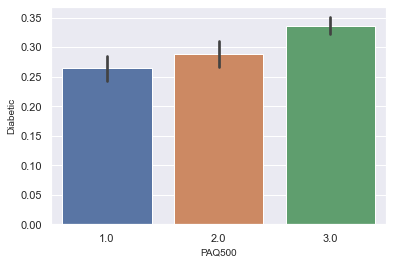

In [702]:
ax =sns.barplot(x="PAQ500", y="Diabetic", data=df_diab4,alpha=1)
df_diab3.groupby(['Diabetic','PAQ520']).size()

In [879]:
ax =sns.scatterplot(x="lbxglu", y="DRXTKCAL", data=df_diab4,alpha=0.4)


In [865]:
feature_int=['RIDAGEYR', 'bmxwt', 'bmxht', 'bmxbmi', 'bmxwaist', 'tot_fat', 'tr_fat',
       'tr_tot_fat', 'arm_fat', 'leg_fat', 'lean_fat', 'RIAGENDR',
       'Fa_hist', 'Bl_pres', 'SMQ', 'HHS','Diabetic','lbxglu']

corr=df_diab7[feature_int].corr()  # Drawing correlation heatmap
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(25, 14))
    ax = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, 
    cmap=sns.diverging_palette(20, 220, n=200), square=True,annot = True,fmt='1.2f')
    rc={'axes.labelsize': 10, 'font.size': 10, 'legend.fontsize': 10, 'axes.titlesize': 10}
    sns.set(rc=rc)
    
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=15)

    ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,
    horizontalalignment='right',
    verticalalignment='bottom',
    fontsize=15      
);
    ax.set_xticklabels(
    ax.get_xticklabels(),
    
    fontsize=15     
);

In [833]:
# diabetic group data
mask_diab_1=df_diab7.Diabetic==1
df_diab_1=df_diab7[mask_diab_1]
# Healthy group data
mask_diab_0=df_diab7.Diabetic==0
df_diab_0=df_diab7[mask_diab_0]

In [834]:
ax =sns.scatterplot(x="tot_fat", y="tr_tot_fat", data=df_diab_0,alpha=1)
ax =sns.scatterplot(x="tot_fat", y="tr_tot_fat", data=df_diab_1,alpha=0.4)

In [328]:
#Exploring the normalized distribution of diabetic and healthy people based on their total fat mass and gender 
from scipy import stats

bins = np.linspace(df_diab4.RIDAGEYR.min(), df_diab4.RIDAGEYR.max(), 30)
g = sns.FacetGrid(df_diab4, col="RIAGENDR", hue="Diabetic",hue_order=[1,0], palette="Set1", col_wrap=2,size=6)
g.map(sns.distplot, 'RIDAGEYR', bins=bins)
g.set(xlabel = 'RIDAGEYR', ylabel = 'Frequency')
rc={'axes.labelsize': 16, 'font.size': 16, 'legend.fontsize': 16, 'axes.titlesize': 18}
sns.set(rc=rc)
#g.axes[-1].legend()
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


The `size` paramter has been renamed to `height`; please update your code.


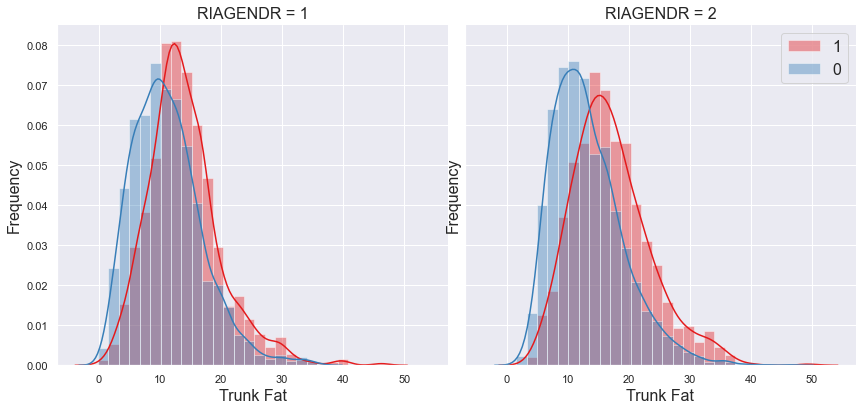

In [993]:
#Exploring the normalized distribution of diabetic and healthy people based on their total fat mass and gender 
from scipy import stats

bins = np.linspace(df_diab6.tr_fat.min(), df_diab6.tr_fat.max(), 30)
g = sns.FacetGrid(df_diab6, col="RIAGENDR", hue="Diabetic",hue_order=[1,0], palette="Set1", col_wrap=2,size=6)
g.map(sns.distplot, 'tr_fat', bins=bins)
g.set(xlabel = 'Trunk Fat', ylabel = 'Frequency')
rc={'axes.labelsize': 16, 'font.size': 16, 'legend.fontsize': 16, 'axes.titlesize': 18}
sns.set(rc=rc)
g.axes[-1].legend()
plt.show()

In [272]:
# diabetic group data
mask_diab_1=df_diab6.Diabetic==1
df_diab_1=df_diab6[mask_diab_1]
# Healthy group data
mask_diab_0=df_diab6.Diabetic==0
df_diab_0=df_diab6[mask_diab_0]

In [868]:
#mask1=(df_diab6.lean_per>=0.7)&(df_diab6.lean_fat>=65)
#df_diab8=df_diab7
mask1=(df_diab6.tr_tot_fat<=0.5)
df_diab7=df_diab8[mask1]
df_diab7.shape

Boolean Series key will be reindexed to match DataFrame index.


(803, 60)

In [271]:
df_diab6
print(df_diab_0['tr_tot_fat'].quantile(.5))
print(df_diab_1['tr_tot_fat'].quantile(.5))

0.4744875211509415
0.5094571753974861


#### Distribution of Total Fat in diabetic males and females is different from non-diabetic males and females. 

The `size` paramter has been renamed to `height`; please update your code.


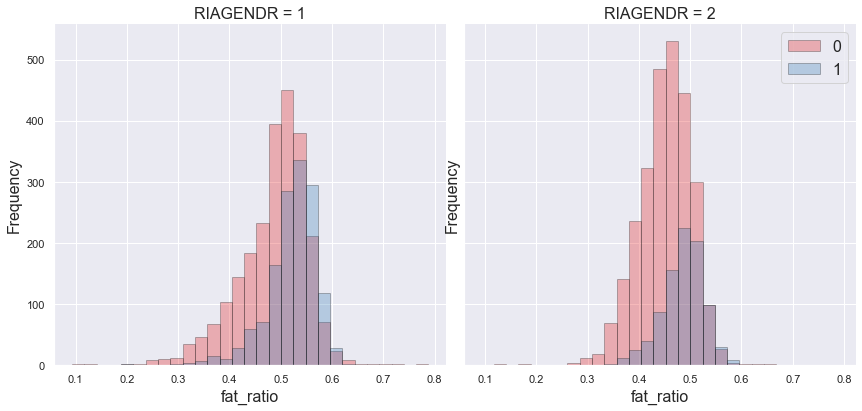

In [773]:
#Exploring the distribution of diabetic and healthy people based on their total fat mass and gender 

bins = np.linspace(df_diab5.tr_tot_fat.min(), df_diab5.tr_tot_fat.max(), 30)
g = sns.FacetGrid(df_diab5, col="RIAGENDR", hue="Diabetic", palette="Set1", col_wrap=2,size=6)
g.map(plt.hist, 'tr_tot_fat', bins=bins, ec="k",alpha=0.3)
g.set(xlabel = 'fat_ratio', ylabel = 'Frequency')
rc={'axes.labelsize': 16, 'font.size': 16, 'legend.fontsize': 16, 'axes.titlesize': 18}
sns.set(rc=rc)
g.axes[-1].legend()
plt.show()

In [587]:
df_diab3.groupby(['Diabetic','RIAGENDR']).size()

Diabetic  RIAGENDR
0         1           2543
          2           3471
1         1           1538
          2           1019
dtype: int64

In [769]:
#Splitting the data in test (20%) and train(80%) sets for FAT & LEAN PREDICTION
from sklearn.model_selection import train_test_split

feature_cont1=['RIDAGEYR','bmxwt','bmxht','bmxbmi','bmxwaist','BMXTHICR',
              'BMXARMC','BMXCALF']

#feature_cat1=['RIAGENDR','RACETH']
feature_cat1=['RIAGENDR']
 
target='DXDTOFAT'
data_cat=df_diab5[feature_cat1+feature_cont1]

y=df_diab5[target]
X_cat0= pd.get_dummies(data=data_cat, columns=feature_cat1, drop_first=True)
X_cat= preprocessing.StandardScaler().fit(X_cat0).transform(X_cat0)

X_train, X_test, y_train, y_test = train_test_split(X_cat, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (6838, 9) (6838,)
Test set: (1710, 9) (1710,)


In [515]:
X_cat0.to_pickle('X_bc.pickle')
#y.to_pickle('Y_bc.pickle')

In [770]:
#LINEAR MODEL FOR FAT& LEAN PREDICTION
from scipy.stats import ttest_ind

def LR(Data,feat_list,target):
    
    feat_reg=feat_list.copy()
    
    X=Data[feat_reg]
    y=Data[target]
    X= preprocessing.StandardScaler().fit(X).transform(X)
    clf = LinearRegression()
    
    LREG_model = clf.fit(X,y)
    y_hat = LREG_model.predict(X)      
    print(LREG_model.score(X,y))
    
#     fig, ax = plt.subplots()
#     ax.scatter(y, y_hat, edgecolors=(0, 0, 1))
#     ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
#     ax.set_xlabel('Measured')
#     ax.set_ylabel('Predicted')
#     plt.show()
    
    return LREG_model

In [771]:
#pickling models for FAT& LEAN PREDICTION
import pickle
feature_cont1=['RIDAGEYR','bmxwt','bmxht','bmxbmi','bmxwaist','BMXTHICR','BMXARMC','BMXCALF']
feature_cat1=['RIAGENDR']
feat_list=feature_cont1+feature_cat1

Total_Fat_model=LR(df_diab5,feat_list,'DXDTOFAT')
pickle.dump(Total_Fat_model, open("Total_Fat_model.pkl","wb"))

Trunk_Fat_model=LR(df_diab5,feat_list,'DXXTRFAT')
pickle.dump(Trunk_Fat_model, open("Trunk_Fat_model.pkl","wb"))

Arm_Fat_model=LR(df_diab5,feat_list,'DXXLAFAT')
pickle.dump(Arm_Fat_model, open("Arm_Fat_model.pkl","wb"))

Leg_Fat_model=LR(df_diab5,feat_list,'DXXLLFAT')
pickle.dump(Leg_Fat_model, open("Leg_Fat_model.pkl","wb"))

Total_Lean_model=LR(df_diab5,feat_list,'DXDTOLE')
pickle.dump(Total_Lean_model, open("Total_Lean_model.pkl","wb"))

0.9167161308760983
0.9065737638201269
0.8594142150736424
0.8279739542073972
0.9309625106419648


In [843]:
#df_diab6["tot_fat"]=

with open('Total_Fat_model.pkl', 'rb') as file:  
    Total_Fat_model = pickle.load(file)   
with open('Trunk_Fat_model.pkl', 'rb') as file:  
    Trunk_Fat_model = pickle.load(file)    
with open('Arm_Fat_model.pkl', 'rb') as file:  
    Arm_Fat_model = pickle.load(file)     
with open('Leg_Fat_model.pkl', 'rb') as file:  
    Leg_Fat_model = pickle.load(file)     
with open('Total_Lean_model.pkl', 'rb') as file:  
    Total_Lean_model = pickle.load(file) 
    
feat_list=feature_cont1+feature_cat1
X=df_diab5[feat_list]
X_ar= preprocessing.StandardScaler().fit(X).transform(X)

df_diab6=df_diab5
df_diab6["tot_fat"]=(Total_Fat_model.predict(X_ar))/1000
df_diab6["tr_fat"]=(Trunk_Fat_model.predict(X_ar))/1000
df_diab6["tr_tot_fat"]=abs((df_diab6["tr_fat"]))/abs(df_diab6["tot_fat"])
df_diab6["arm_fat"]=(Arm_Fat_model.predict(X_ar))/1000
df_diab6["leg_fat"]=(Leg_Fat_model.predict(X_ar))/1000
df_diab6["lean_fat"]=(Total_Lean_model.predict(X_ar))/1000
df_diab6["lean_per"]=df_diab6["lean_fat"]/df_diab6["bmxwt"]
df_diab6["lean_index"]=df_diab6["lean_fat"]/((df_diab6["bmxht"])**2)*10000
df_diab6["fat_lean"]=df_diab6["tot_fat"]/(abs(df_diab6["lean_fat"]))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user

In [845]:
df_diab6["lean_index"].quantile(0.8)
# df_diab7= outliers_IQR2(df_diab6,'tot_fat',3)
# df_diab7= outliers_IQR2(df_diab7,'tr_tot_fat',3)

print(df_diab6.shape)

(8548, 60)


In [831]:
sns.distplot(df_diab7.tr_tot_fat)
df_diab6["tr_tot_fat"].quantile(0.9)

#df_diab6.tr_tot_fat.min()

0.5457615843277225

In [151]:
df_diab6.columns

Index(['lbxglu', 'RIAGENDR', 'RIDAGEYR', 'RACETH', 'DRXTKCAL', 'DRXTCARB',
       'DRXTPROT', 'DRXTTFAT', 'DRXTSFAT', 'bmxwt', 'bmxht', 'bmxbmi',
       'bmxwaist', 'BMXTHICR', 'BMXARMC', 'BMXLEG', 'BMXCALF', 'BMXARML',
       'MCQ250A', 'BPQ020', 'PAD020', 'PAD080', 'PAQ100', 'PAD120', 'PAD160',
       'PAQ480', 'PAQ050Q', 'PAQ050U', 'PAQ540', 'PAQ500', 'PAQ520', 'SMQ020',
       'SMQ040', 'DMDEDUC2', 'DMDHHSIZ', 'DXDTOFAT', 'DXDTOLE', 'DXXTRFAT',
       'DXXLAFAT', 'DXXLLFAT', 'Diabetic', 'min_act', 'W', 'Act', 'Act_level',
       'cal_level', 'Inact', 'Bl_pres', 'Fa_hist', 'SMQ', 'Educ', 'HHS',
       'tot_fat', 'tr_fat', 'tr_tot_fat', 'arm_fat', 'leg_fat', 'lean_fat',
       'lean_per'],
      dtype='object')

###  Machine learning models (Logistic regression, Random forest, SVM, Naive Bayes ) are appleid for this classification problem

In [957]:
#df_diab6=df_diab5

print(df_diab7.shape)
                     
#Splitting the data in test (20%) and train(80%) sets 
from sklearn.model_selection import train_test_split

feature_int=['tot_fat','tr_fat','tr_tot_fat','arm_fat','leg_fat','lean_fat']
#feature_int=['tot_fat','tr_tot_fat','lean_fat']

# feature_cont=['RIDAGEYR','DRXTKCAL','DRXTCARB','DRXTPROT','bmxwt','bmxht','bmxbmi',
#               'bmxwaist','Act','fat_ratio','WCI','DXDTOFAT','DXDTOLE','DXXLLFAT','DXXLAFAT']

feature_cont=['RIDAGEYR','bmxwt','bmxht','bmxbmi','bmxwaist']
#feature_cont=['RIDAGEYR','bmxwt','bmxht','bmxbmi']
# feature_cat=['RIAGENDR','RACETH','MCQ250A','BPQ020','SMQ020',
#             'HHS','min_act','Inact','PAQ540','PAQ500','PAQ520']

#feature_cat=['RIAGENDR','Fa_hist','Bl_pres','SMQ','HHS','Educ','Act_level','Inact']

feature_cat=['RIAGENDR','Fa_hist','Bl_pres','SMQ','HHS']

data_cat=df_diab6[feature_cat+feature_cont+feature_int]
data_cat2=df_diab7[feature_cat+feature_cont+feature_int]

#data_cat=df_diab6[feat_test]

#X=df_diab4[feature_cont+feature_cat]

y=df_diab6['Diabetic']
X_cat0= pd.get_dummies(data=data_cat, columns=feature_cat, drop_first=True)
#X_cat0= pd.get_dummies(data=data_cat, columns=['RIAGENDR'], drop_first=True)

X_cat= preprocessing.StandardScaler().fit(X_cat0).transform(X_cat0)
#X_cat= preprocessing.StandardScaler().fit_transform(X_cat)
#X_cat= pd.get_dummies(data=data_cat, columns=feature_cat, drop_first=True)
#X_cat= pd.get_dummies(data=data_cat, columns=['RIAGENDR'], drop_first=True)

X_cat02= pd.get_dummies(data=data_cat2, columns=feature_cat, drop_first=True)
X_cat2= preprocessing.StandardScaler().fit(X_cat02).transform(X_cat02)
y_test2=df_diab7['Diabetic']
print(X_cat02.shape)

X_train, X_test, y_train, y_test = train_test_split(X_cat, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)


(803, 60)
(803, 16)
Train set: (6838, 16) (6838,)
Test set: (1710, 16) (1710,)


invalid value encountered in true_divide
invalid value encountered in double_scalars
invalid value encountered in true_divide
invalid value encountered in double_scalars


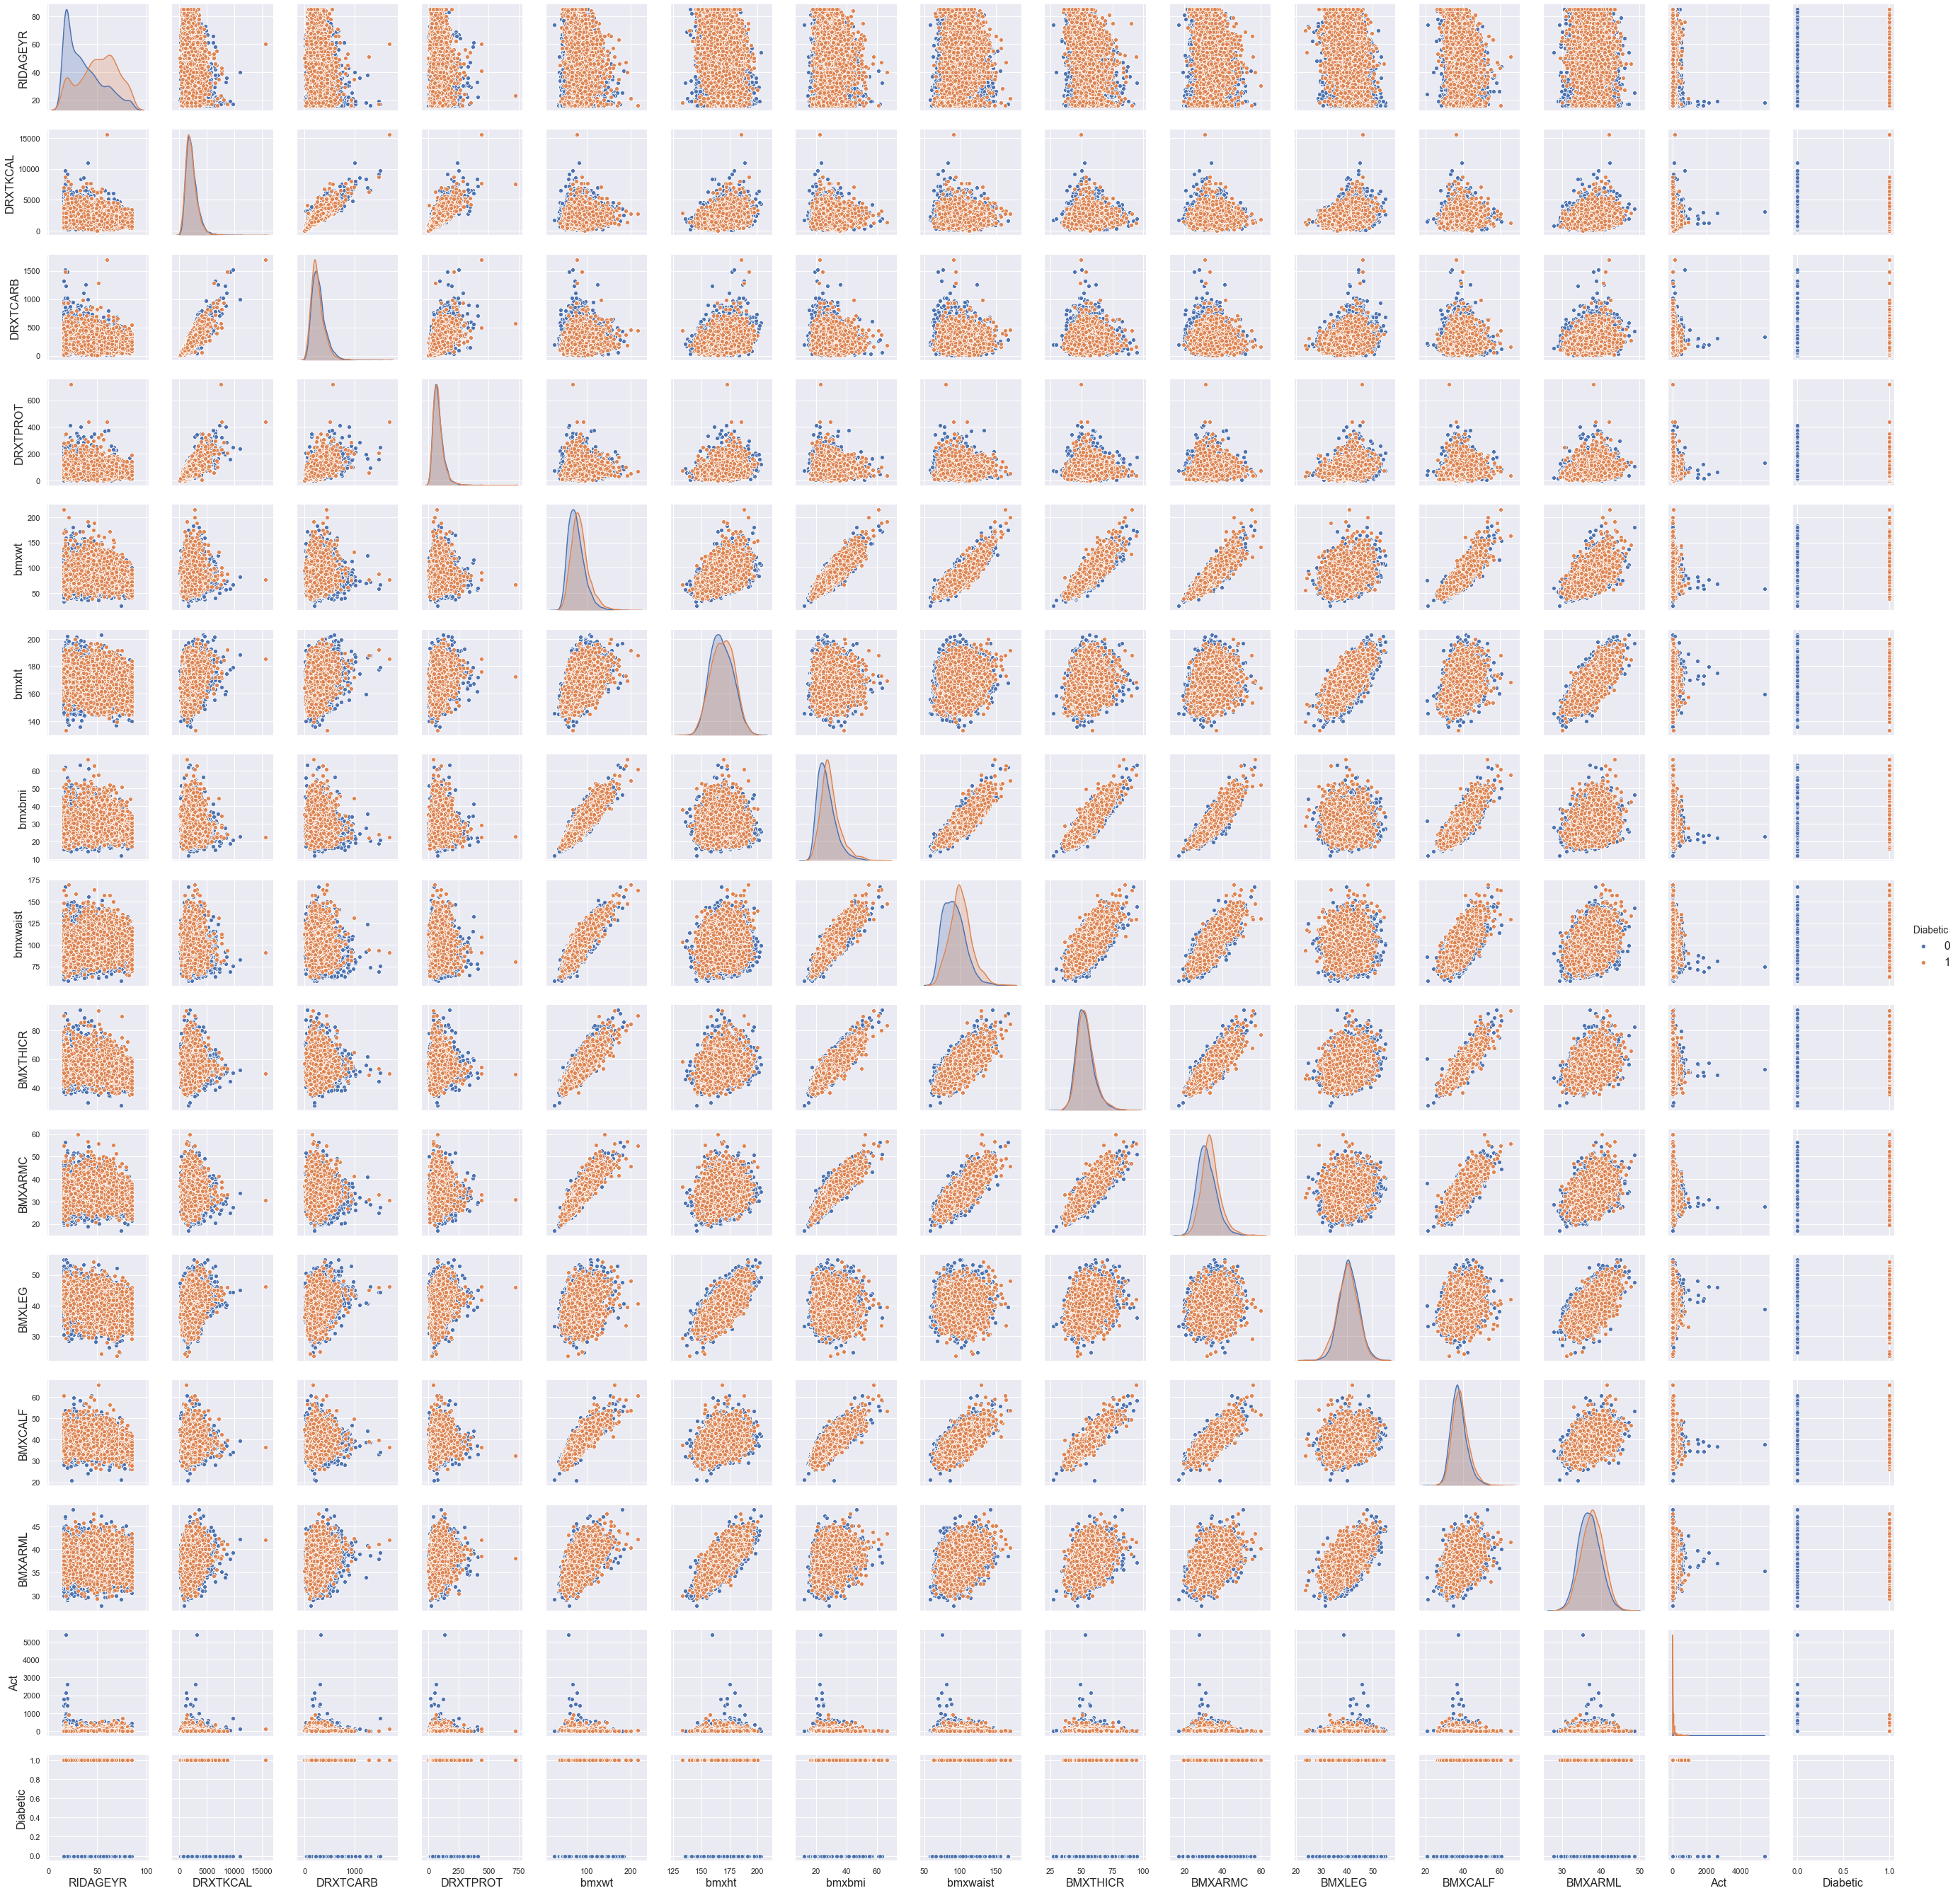

In [468]:
sns_plot = sns.pairplot(df_diab4[feature_cont3+['Diabetic']], hue='Diabetic', size=2.5)
#sns_plot.savefig("output.png")

In [867]:
X_cat0.columns

Index(['RIDAGEYR', 'bmxwt', 'bmxht', 'bmxbmi', 'RIAGENDR_2', 'Fa_hist_1',
       'Bl_pres_1', 'SMQ_1'],
      dtype='object')

In [637]:
X_cat0.to_pickle('X_train.pickle')
y.to_pickle('Y_train.pickle')

### - Logistic regression:
- The confusion matrix and classification report metrics are printed showing the performance of the model.

In [953]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
LR_model = LogisticRegression(C=0.01, class_weight='balanced').fit(X_train,y_train)
#LR_model = CalibratedClassifierCV(est, cv=3, method='sigmoid').fit(X_train,y_train)

#yhat = LR_model.predict(X_test)
yhat = LR_model.predict(X_cat2)

print (classification_report(y_test2,yhat ))
print(confusion_matrix(y_test2, yhat, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.93      0.61      0.74       730
           1       0.12      0.53      0.20        73

    accuracy                           0.60       803
   macro avg       0.52      0.57      0.47       803
weighted avg       0.86      0.60      0.69       803

[[446 284]
 [ 34  39]]


In [983]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
LR_model = LogisticRegression(C=0.01, class_weight='balanced').fit(X_train,y_train)
#LR_model = CalibratedClassifierCV(LR_model, cv=3, method='sigmoid').fit(X_train,y_train)

yhat = LR_model.predict(X_test)
#yhat = LR_model.predict(X_cat2)

print (classification_report(y_test,yhat ))
print(confusion_matrix(y_test, yhat, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.85      0.69      0.76      1202
           1       0.49      0.71      0.58       508

    accuracy                           0.69      1710
   macro avg       0.67      0.70      0.67      1710
weighted avg       0.74      0.69      0.71      1710

[[826 376]
 [147 361]]


### -Random Forest:

In [959]:
from sklearn.ensemble import RandomForestClassifier
RF_model =RandomForestClassifier(max_depth=9, random_state=1,class_weight='balanced').fit(X_train,y_train)

yhat = RF_model.predict(X_test)

print (classification_report(y_test,yhat ))
print(confusion_matrix(y_test, yhat, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.82      0.75      0.78      1202
           1       0.51      0.62      0.56       508

    accuracy                           0.71      1710
   macro avg       0.67      0.69      0.67      1710
weighted avg       0.73      0.71      0.72      1710

[[900 302]
 [192 316]]


In [897]:
RF_model.score(X_test, y_test)

0.7

In [908]:
from sklearn.inspection import permutation_importance
r = permutation_importance(RF_model, X_cat, y,
                            n_repeats=30,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print( f"{X_cat0.columns[i]:<8}"
                   f"{ r.importances_mean[i]:.3f}"
                   f" +/- { r.importances_std[i]:.3f}")

RIDAGEYR0.080 +/- 0.004
tr_tot_fat0.017 +/- 0.003
bmxht   0.007 +/- 0.001
bmxbmi  0.007 +/- 0.002
Bl_pres_10.007 +/- 0.001
arm_fat 0.004 +/- 0.001
lean_fat0.003 +/- 0.002
HHS_1   0.002 +/- 0.001


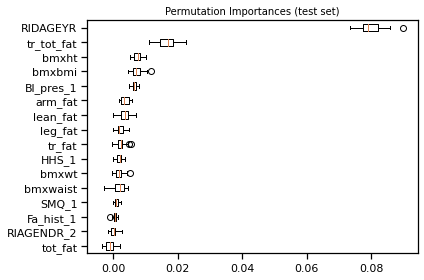

In [909]:
sorted_idx = r.importances_mean.argsort()
fig, ax = plt.subplots()
ax.boxplot(r.importances[sorted_idx].T,
           vert=False, labels=X_cat0.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()


In [907]:
from sklearn.inspection import permutation_importance
r = permutation_importance(RF_model, X_test, y_test,
                            n_repeats=30,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     #if r.importances_mean[i] - 1 * r.importances_std[i] > 0:
            print( f"{X_cat0.columns[i]:<10}"
                    f"{r.importances_mean[i]:.3f}"
                    f" +/- {r.importances_std[i]:.3f}")

RIDAGEYR  0.068 +/- 0.008
bmxht     0.003 +/- 0.002
tr_tot_fat0.003 +/- 0.005
Fa_hist_1 0.001 +/- 0.001
SMQ_1     -0.000 +/- 0.001
HHS_1     -0.001 +/- 0.001
bmxbmi    -0.001 +/- 0.003
Bl_pres_1 -0.001 +/- 0.001
arm_fat   -0.001 +/- 0.002
tr_fat    -0.005 +/- 0.003
tot_fat   -0.006 +/- 0.002
bmxwt     -0.006 +/- 0.003
leg_fat   -0.007 +/- 0.002
RIAGENDR_2-0.007 +/- 0.002
bmxwaist  -0.008 +/- 0.003
lean_fat  -0.009 +/- 0.003


In [856]:
RF_model =RandomForestClassifier(max_depth=7, random_state=1,class_weight='balanced').fit(X_train,y_train)

yhat = RF_model.predict(X_cat2)

print (classification_report(y_test2,yhat ))
print(confusion_matrix(y_test2, yhat, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.92      0.71      0.80       730
           1       0.12      0.40      0.19        73

    accuracy                           0.68       803
   macro avg       0.52      0.55      0.49       803
weighted avg       0.85      0.68      0.75       803

[[520 210]
 [ 44  29]]


In [738]:
pip install xgboost==0.82

Note: you may need to restart the kernel to use updated packages.


In [434]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [49]:
pip install altair

Note: you may need to restart the kernel to use updated packages.


In [963]:
import xgboost as xgb

#XG_model = xgb.train({'objective':'reg:linear'}, xgb.DMatrix(X_train, label=y_train))
XG_model=XGBClassifier(silent=False,n_estimators=10, max_depth=7, gamma= 1, random_state=1,learning_rate=0.1).fit(X_train, y_train)
XG_model=XGBClassifier(silent=False,n_estimators=100, max_depth=5, min_child_weight = 1 ,
                       gamma= 1, random_state=1,learning_rate=0.1, colsample_bytree = 0.8, scale_pos_weight = 1).fit(X_train, y_train)

#XG_model = CalibratedClassifierCV(XG_model, cv=3, method='sigmoid').fit(X_train,y_train)
yhat = XG_model.predict(X_test)

print (classification_report(y_test,yhat ))
print(confusion_matrix(y_test, yhat, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.78      0.90      0.83      1202
           1       0.62      0.38      0.47       508

    accuracy                           0.75      1710
   macro avg       0.70      0.64      0.65      1710
weighted avg       0.73      0.75      0.73      1710

[[1082  120]
 [ 313  195]]


In [608]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [610]:
xgb.plot_tree(XG_model,num_trees=0)

ExecutableNotFound: failed to execute ['dot', '-Tpng'], make sure the Graphviz executables are on your systems' PATH

In [964]:
from sklearn.neighbors import KNeighborsClassifier
Knn_model= KNeighborsClassifier(n_neighbors=10, weights='uniform').fit(X_train,y_train)
yhat = Knn_model.predict(X_test)

print (classification_report(y_test,yhat ))
print(confusion_matrix(y_test, yhat, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.75      0.91      0.82      1202
           1       0.56      0.28      0.37       508

    accuracy                           0.72      1710
   macro avg       0.65      0.59      0.59      1710
weighted avg       0.69      0.72      0.69      1710

[[1092  110]
 [ 368  140]]


In [348]:
logReg_coeff = pd.DataFrame({'feature_name': X_cat0.columns, 'model_coefficient': abs(LR_model.coef_.transpose().flatten())})
logReg_coeff = logReg_coeff.sort_values('model_coefficient',ascending=False)
logReg_coeff_top = logReg_coeff.head(20)
# logReg_coeff_bottom = logReg_coeff.tail(20)
    # Plot top 5 coefficients
plt.figure().set_size_inches(10, 8)
#fg3 = sns.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_top, palette="Blues_d",orient='h')
fg3 = sns.barplot(x='model_coefficient', y='feature_name',data=logReg_coeff_top, palette="Blues_d",orient='h')
fg3.set_yticklabels(rotation=35, labels=logReg_coeff_top.feature_name)
   # Plot bottom 5 coefficients
# plt.figure().set_size_inches(10,6)
# fg4 = sns.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_bottom, palette="GnBu_d")
# fg4.set_xticklabels(rotation=35, labels=logReg_coeff_bottom.feature_name)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
# plt.subplots_adjust(bottom=0.4)
# plt.savefig('figure_4.png')

AttributeError: 'CalibratedClassifierCV' object has no attribute 'coef_'

In [859]:
feature_importance = abs(LR_model.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_cat0.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

In [965]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

ns_probs = [0 for _ in range(len(y_test))]
lr_probs = LR_model.predict_proba(X_test)
rf_probs= RF_model.predict_proba(X_test)
Knn_probs= Knn_model.predict_proba(X_test)
XG_probs= XG_model.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
rf_probs = rf_probs[:, 1]
Knn_probs = Knn_probs[:, 1]
XG_probs = XG_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
Knn_auc = roc_auc_score(y_test, Knn_probs)
XG_auc = roc_auc_score(y_test, XG_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
print('Random Forest: ROC AUC=%.3f' % (rf_auc))
print('Knn: ROC AUC=%.3f' % (Knn_auc))
print('XG: ROC AUC=%.3f' % (XG_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
Knn_fpr, Knn_tpr, _ = roc_curve(y_test, Knn_probs)
XG_fpr, XG_tpr, _ = roc_curve(y_test, XG_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='', label='Logistic_Regression')
plt.plot(rf_fpr, rf_tpr, marker='', label='Random_Forest')
plt.plot(Knn_fpr, Knn_tpr, marker='', label='Knn')
#plt.plot(XG_fpr, XG_tpr, marker='', label='XGboost')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend(prop={'size': 12})
# show the plot
plt.show()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.759
Random Forest: ROC AUC=0.762
Knn: ROC AUC=0.714
XG: ROC AUC=0.763


In [979]:
lr_probs = LR_model.predict_proba(X_cat)
rf_probs = RF_model.predict_proba(X_cat)
XG_probs = XG_model.predict_proba(X_cat)

lr_diab_prob=lr_probs[:,1]
rf_diab_prob=rf_probs[:,1]
xg_diab_prob=XG_probs[:,1]
#ax=sns.distplot(prob)
#sns.distplot(df_diab3.lbxglu/100 , color="olive",)
ax=sns.scatterplot(x=lr_diab_prob,y=df_diab4.lbxglu,alpha=1)
ax=sns.scatterplot(x=rf_diab_prob,y=df_diab4.lbxglu,alpha=0.3)
ax=sns.scatterplot(x=xg_diab_prob,y=df_diab4.lbxglu,alpha=0.3)

#sns.scatterplot(x=rf_diab_prob,y=df_diab4.Diabetic)

In [982]:
#ax2=sns.distplot(lr_diab_prob,bins=40)
ax2=sns.distplot(rf_diab_prob,bins=100,norm_hist=True)
#ax2=sns.distplot(xg_diab_prob,bins=40,norm_hist=True)
print(rf_probs[:,0])
print(rf_probs[:,1])


[0.32577121 0.42324224 0.58923562 ... 0.41522122 0.48591343 0.77945208]
[0.67422879 0.57675776 0.41076438 ... 0.58477878 0.51408657 0.22054792]


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.750


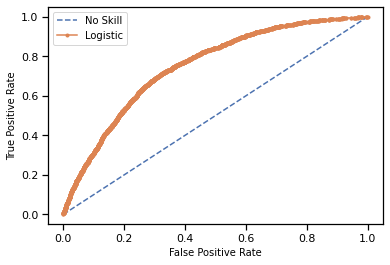

In [484]:
ns_probs = [0 for _ in range(len(y_train))]
lr_probs = LR_model.predict_proba(X_train)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_train, ns_probs)
lr_auc = roc_auc_score(y_train, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_train, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_train, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [407]:
pip install shap

     |████████████████████████████████| 276kB 2.2MB/s eta 0:00:01
  Created wheel for shap: filename=shap-0.35.0-cp37-cp37m-macosx_10_9_x86_64.whl size=307123 sha256=6585f2c7b5f68ccdf0fd833a8526e5693c51feff540bd442c631320629db5220
  Stored in directory: /Users/Ali/Library/Caches/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap
Note: you may need to restart the kernel to use updated packages.


In [951]:
X_cat0.columns

Index(['RIDAGEYR', 'bmxwt', 'bmxht', 'bmxbmi', 'RIAGENDR_2', 'Fa_hist_1',
       'Bl_pres_1', 'SMQ_1', 'HHS_1'],
      dtype='object')

In [535]:
import shap
shap_values = shap.TreeExplainer(XG_model).shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


TypeError: predict() got an unexpected keyword argument 'validate_features'

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


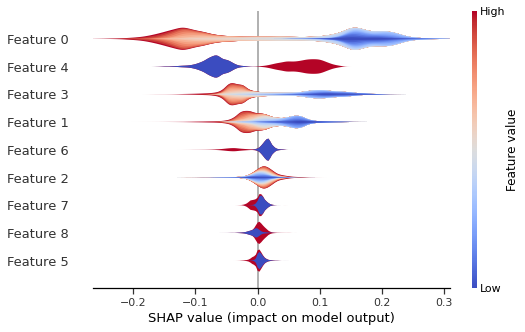

In [950]:
shap_values = shap.TreeExplainer(RF_model).shap_values(X_train)
shap.summary_plot(shap_values[0], X_train, plot_type="layered_violin")

In [861]:
X_cat0.columns

Index(['RIDAGEYR', 'bmxwt', 'bmxht', 'bmxbmi', 'bmxwaist', 'tot_fat', 'tr_fat',
       'tr_tot_fat', 'arm_fat', 'leg_fat', 'lean_fat', 'RIAGENDR_2',
       'Fa_hist_1', 'Bl_pres_1', 'SMQ_1', 'HHS_1'],
      dtype='object')

In [938]:
import shap
shap_values = shap.TreeExplainer(RF_model).shap_values(X_train)
shap.summary_plot(shap_values[0], X_train, plot_type="layered_violin")

#shap.summary_plot(shap_values[0], X_train, plot_type="bar")
#.shap_values(X_train)
# explainerXGB = shap.TreeExplainer(xgb_model)
# shap_values_XGB_test = explainerXGB.shap_values(X_test)
# shap_values_XGB_train = explainerXGB.shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


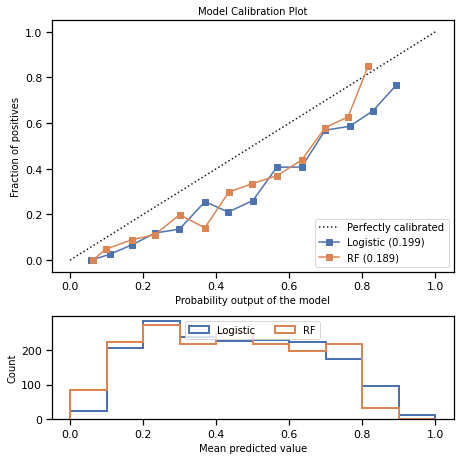

In [984]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve


def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')
    

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1.,class_weight='balanced')
    sigmoid_lr = CalibratedClassifierCV(lr, cv=2, method='sigmoid')
    
    fig = plt.figure(fig_index, figsize=(6.5, 6.5))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      ]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
#         print("%s:" % name)
#         print("\tBrier: %1.3f" % (clf_score))
#         print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
#         print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
#         print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=15)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_xlabel("Probability output of the model")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Model Calibration Plot')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

# Plot calibration curve for Gaussian Naive Bayes
#plot_calibration_curve(GaussianNB(), "Naive Bayes", 1)

# Plot calibration curve for Linear SVC
#plot_calibration_curve(LinearSVC(max_iter=10000), "SVC", 2)

plot_calibration_curve(xgb.XGBClassifier(random_state=1,learning_rate=0.1, scale_pos_weight = 1, class_weight='balanced'), "XGBoost", 1)
#plot_calibration_curve(xgb.XGBClassifier(random_state=1,learning_rate=0.1, scale_pos_weight = 1, class_weight='balanced'), "XGBoost", 1)

plot_calibration_curve(RandomForestClassifier(max_depth=7, random_state=0,class_weight='balanced'), "RF", 1)
#plot_calibration_curve(LogisticRegression(C=0.01,class_weight='balanced'),'LR',2)

plt.show()

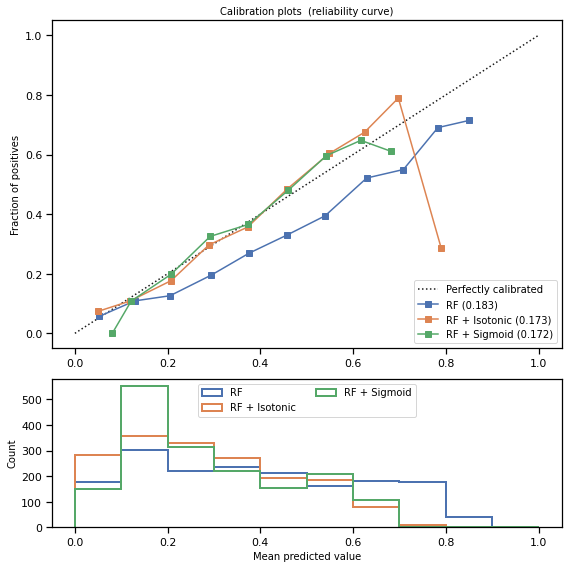

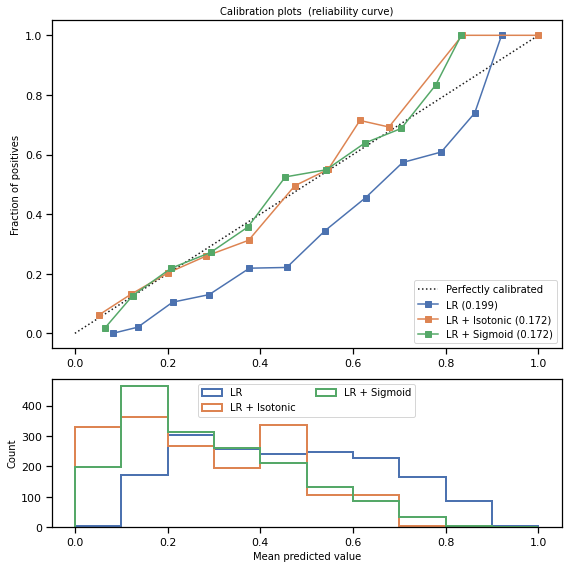

In [369]:
def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=3, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=3, method='sigmoid')

    # Logistic regression with no calibration as baseline

    fig = plt.figure(fig_index, figsize=(8, 8))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=12)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()


plot_calibration_curve(RandomForestClassifier(max_depth=10, random_state=0,class_weight='balanced'), "RF", 1)
plot_calibration_curve(LogisticRegression(C=0.01,class_weight='balanced'),'LR',2)


plt.show()

In [966]:
import pickle
pickle.dump(RF_model, open("LR_model1.pkl","wb"))

In [334]:
with open('LR_model1.pkl', 'rb') as file:  
    Pickled_LR_Model = pickle.load(file)

Pickled_LR_Model

CalibratedClassifierCV(base_estimator=LogisticRegression(C=0.01,
                                                         class_weight='balanced',
                                                         dual=False,
                                                         fit_intercept=True,
                                                         intercept_scaling=1,
                                                         l1_ratio=None,
                                                         max_iter=100,
                                                         multi_class='auto',
                                                         n_jobs=None,
                                                         penalty='l2',
                                                         random_state=None,
                                                         solver='lbfgs',
                                                         tol=0.0001, verbose=0,
                                       

In [339]:
Risk=Pickled_LR_Model.predict_proba(dff_ar)[:,1]*100
Risk


array([26.28690436])

In [268]:
df_diab6.columns

Index(['lbxglu', 'RIAGENDR', 'RIDAGEYR', 'RACETH', 'DRXTKCAL', 'DRXTCARB',
       'DRXTPROT', 'DRXTTFAT', 'DRXTSFAT', 'bmxwt', 'bmxht', 'bmxbmi',
       'bmxwaist', 'BMXTHICR', 'BMXARMC', 'BMXLEG', 'BMXCALF', 'BMXARML',
       'MCQ250A', 'BPQ020', 'PAQ480', 'PAQ540', 'PAQ500', 'PAQ520', 'SMQ020',
       'SMQ040', 'DMDEDUC2', 'DMDHHSIZ', 'RIDEXPRG', 'DXDTOFAT', 'DXDTOLE',
       'DXXTRFAT', 'DXXLAFAT', 'DXXLLFAT', 'Diabetic', 'min_act', 'Act',
       'Act_level', 'Inact', 'HHS', 'fat_ratio1', 'fat_ratio2', 'fat_ratio3',
       'fat_ratio', 'fat_per', 'fat_per2', 'WCI', 'Cal_age'],
      dtype='object')

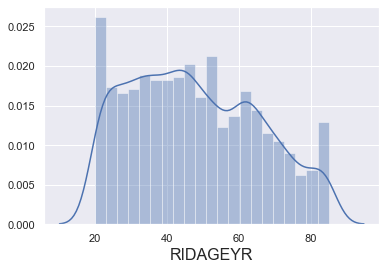

In [344]:
df_diab6.RIDAGEYR.max()
sns.distplot(df_diab6.RIDAGEYR)

In [331]:
#data = [['RIDAGEYR', 20,1], ['bmxbmi', 45,1], ['bmxwaist', 85,1],['RIAGENDR_2', 1,1]] 
inputs = [[30, 80,170,30,40,30,14,0.4,4,6,16,1,1,1,1,1]] 

# Create the pandas DataFrame 

dff = pd.DataFrame(inputs, columns = ['RIDAGEYR', 'bmxwt', 'bmxht', 'bmxbmi', 'bmxwaist', 'tot_fat', 'tr_fat',
   'tr_tot_fat', 'arm_fat', 'leg_fat', 'lean_fat', 'RIAGENDR_2',
   'Fa_hist_1', 'Bl_pres_1', 'SMQ_1', 'HHS_1'])
dff_ar= preprocessing.StandardScaler().fit(dff).transform(dff)

#dff_ar= preprocessing.StandardScaler().fit(dff).transform(dff)
print(dff_ar)
dff


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


RIDAGEYR  bmxwt  bmxht  bmxbmi  bmxwaist  tot_fat  tr_fat  tr_tot_fat  \
0        30     80    170      30        40       30      14         0.4   

   arm_fat  leg_fat  lean_fat  RIAGENDR_2  Fa_hist_1  Bl_pres_1  SMQ_1  HHS_1  
0        4        6        16           1          1          1      1      1

In [319]:
#df['column_name']=pd.Series(rf_probs)
DIS=pd.DataFrame()
hist_values = np.histogram(lr_diab_prob,bins=100, range=(0,1),normed=True)
DIS['Freq']=pd.Series(hist_values[0])
DIS['Prob']=pd.Series(hist_values[1])
DIS
#hist_values[0]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  This is separate from the ipykernel package so we can avoid doing imports until


Freq  Prob
0   0.000000  0.00
1   0.000000  0.01
2   0.000000  0.02
3   0.000000  0.03
4   0.000000  0.04
..       ...   ...
95  0.011699  0.95
96  0.000000  0.96
97  0.000000  0.97
98  0.000000  0.98
99  0.011699  0.99

[100 rows x 2 columns]

In [342]:
import altair as alt

Risk=np.round_(Risk/100,decimals = 2)
Risk=np.asscalar(Risk)
alt.Chart(DIS).mark_bar().encode(
    x='Prob',
    y="Freq",
    # The highlight will be set on the result of a conditional statement
    color=alt.condition(
        alt.datum.Prob == Risk,  # If the year is 1810 this test returns True,
        alt.value('orange'),     # which sets the bar orange.
        alt.value('steelblue')   # And if it's not true it sets the bar steelblue.
    )
).properties(width=600)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  after removing the cwd from sys.path.


alt.Chart(...)

In [247]:
Risk

0.19

In [968]:
DIS['Risk'] = Risk

chart_one = alt.Chart(DIS).mark_bar().encode(
    alt.X('Prob:Q', scale=alt.Scale(domain=(0.1, 0.9)), axis=alt.Axis(format='%', title='Diabetes Risk')),
    alt.Y("Freq",axis=alt.Axis(title='Relative Frequency'))
)

chart_two = alt.Chart(DIS).mark_rule(color='red').encode(x='Risk',size=alt.value(2))

(chart_one+chart_two).properties(width=600)



alt.LayerChart(...)

### -SVM:

In [363]:
from sklearn.svm import SVC
SVC_model =SVC(kernel='linear',class_weight='balanced').fit(X_train,y_train)

yhat = SVC_model.predict(X_test)

print (classification_report(y_test,yhat))
print(confusion_matrix(y_test, yhat, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.85      0.69      0.76      1202
           1       0.49      0.72      0.58       508

    accuracy                           0.70      1710
   macro avg       0.67      0.70      0.67      1710
weighted avg       0.75      0.70      0.71      1710

[[829 373]
 [144 364]]


### -Naive bayes:

In [361]:
from sklearn.naive_bayes import GaussianNB
NB_model =GaussianNB().fit(X_train,y_train)

yhat = NB_model.predict(X_test)

print (classification_report(y_test,yhat))
print(confusion_matrix(y_test, yhat, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.74      0.90      0.81      1202
           1       0.49      0.24      0.32       508

    accuracy                           0.70      1710
   macro avg       0.62      0.57      0.57      1710
weighted avg       0.66      0.70      0.66      1710

[[1077  125]
 [ 386  122]]


In [356]:
from PIL import Image
filename = "body1.jpeg"
with Image.open(filename) as image: 
    width, height = image.size
image.show ()

AttributeError: 'NoneType' object has no attribute 'seek'

In [358]:
from PIL import Image
im = Image.open("body1.jpeg")
im.show()

In [979]:
from PIL import Image, ImageDraw, ImageFont    
image = Image.open("body.jpg")
draw  = ImageDraw.Draw(image)
#font  = ImageFont.truetype("arial.ttf", 10)
#draw.text( (40,40), u"Fat", fill='#a00000')
fill1='red'
fill2='blue'

#draw.ellipse((65, 75, 95, 145), fill=fill1, outline =None)
draw.ellipse((40, 80, 50, 100), fill=fill1, outline =None)
draw.ellipse((108, 80, 118, 100), fill=fill1, outline =None)
draw.ellipse((58, 165, 70, 200), fill=fill1, outline =None)
draw.ellipse((94, 165, 106, 200), fill=fill1, outline =None)

#text = 'LAUGHING IS THE \n BEST MEDICINE'
  
# drawing text size 
#draw.text((40, 40), text,fill='red' ,align ="left") 
image.show()
#image.save("out.png","PNG")

- rrr

In [743]:
df_diab6.columns

Index(['lbxglu', 'RIAGENDR', 'RIDAGEYR', 'RACETH', 'DRXTKCAL', 'DRXTCARB',
       'DRXTPROT', 'DRXTTFAT', 'DRXTSFAT', 'bmxwt', 'bmxht', 'bmxbmi',
       'bmxwaist', 'BMXTHICR', 'BMXARMC', 'BMXLEG', 'BMXCALF', 'BMXARML',
       'MCQ250A', 'BPQ020', 'PAQ480', 'PAQ540', 'PAQ500', 'PAQ520', 'SMQ020',
       'SMQ040', 'DMDEDUC2', 'DMDHHSIZ', 'RIDEXPRG', 'DXDTOFAT', 'DXDTOLE',
       'DXXTRFAT', 'DXXLAFAT', 'DXXLLFAT', 'Diabetic', 'min_act', 'Act',
       'Act_level', 'Inact', 'Bl_pres', 'Fa_hist', 'SMQ', 'HHS', 'Educ',
       'tot_fat', 'tr_fat', 'tr_tot_fat', 'arm_fat', 'leg_fat', 'lean_fat'],
      dtype='object')

In [5]:
import numpy as np
import statsmodels.api as sm
X=df_diab6[['bmxwt']]
y=df_diab6['bmxwaist']
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

NameError: name 'df_diab6' is not defined

In [531]:
pip install searchgrid

  Created wheel for searchgrid: filename=searchgrid-0.2.0-cp37-none-any.whl size=5763 sha256=669d4bff6db84219f48ca3a15085e4f846c6024bd1467de0205d69d20e0612af
  Stored in directory: /Users/Ali/Library/Caches/pip/wheels/c0/9e/bc/d2faf5fa8b1a478cb8aa6bc255797b0e96d1131b2fcbe2810f
Successfully built searchgrid
Note: you may need to restart the kernel to use updated packages.


In [587]:
#Import libraries:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
#from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

# train = pd.read_csv('train_modified.csv')
# target = 'Disbursed'
# IDcol = 'ID'

ModuleNotFoundError: No module named 'sklearn.grid_search'

In [537]:
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc","error"]
%time XG_model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.768085	validation_0-error:0.260603	validation_1-auc:0.745988	validation_1-error:0.268421
[1]	validation_0-auc:0.778858	validation_0-error:0.255192	validation_1-auc:0.745913	validation_1-error:0.272515
[2]	validation_0-auc:0.785494	validation_0-error:0.251243	validation_1-auc:0.747474	validation_1-error:0.275439
[3]	validation_0-auc:0.792464	validation_0-error:0.243346	validation_1-auc:0.749159	validation_1-error:0.27076
[4]	validation_0-auc:0.798106	validation_0-error:0.239982	validation_1-auc:0.753077	validation_1-error:0.265497
[5]	validation_0-auc:0.803508	validation_0-error:0.236619	validation_1-auc:0.752037	validation_1-error:0.263743
[6]	validation_0-auc:0.805291	validation_0-error:0.23618	validation_1-auc:0.751924	validation_1-error:0.263743
[7]	validation_0-auc:0.809949	validation_0-error:0.232378	validation_1-auc:0.75261	validation_1-error:0.265497
[8]	validation_0-auc:0.812409	validation_0-error:0.231647	validation_1-auc:0.753072	validation_1-error:0.26

[73]	validation_0-auc:0.938	validation_0-error:0.126645	validation_1-auc:0.718185	validation_1-error:0.287134
[74]	validation_0-auc:0.938524	validation_0-error:0.125329	validation_1-auc:0.717443	validation_1-error:0.28655
[75]	validation_0-auc:0.939003	validation_0-error:0.12489	validation_1-auc:0.717957	validation_1-error:0.284211
[76]	validation_0-auc:0.940154	validation_0-error:0.123428	validation_1-auc:0.717358	validation_1-error:0.28538
[77]	validation_0-auc:0.941545	validation_0-error:0.122404	validation_1-auc:0.715437	validation_1-error:0.287134
[78]	validation_0-auc:0.942127	validation_0-error:0.121234	validation_1-auc:0.714899	validation_1-error:0.287134
[79]	validation_0-auc:0.943843	validation_0-error:0.120942	validation_1-auc:0.714775	validation_1-error:0.288304
[80]	validation_0-auc:0.944412	validation_0-error:0.120503	validation_1-auc:0.714965	validation_1-error:0.289474
[81]	validation_0-auc:0.945692	validation_0-error:0.119918	validation_1-auc:0.715124	validation_1-erro

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=4, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)